# Maximum AI Cost by Prevalence Analysis (Optimized)

This notebook finds the **maximum AI screening cost** at different prevalence levels.

**Key Optimization**: Run PSA only ONCE, then adjust prevalence and AI costs in the trace tensor.

**Prevalence Scenarios**: 1%, 2%, 3%, 4%, 5%, 6%, 7%, 10%

**AI Costs Tested**: €0 to €60 in €2 increments per prevalence

## 1. Setup and Imports

In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import copy

sys.path.append('../src')

from glaucoma_model.parameters import (
    Parameter,
    GlaucomaParameters
)

from glaucoma_model.model import (
    BaseGlaucomaModel,
    AIGlaucomaModel,
    NonAIGlaucomaModel
)

from glaucoma_model.analysis import (
    comprehensive_cost_effectiveness_analysis,
    create_summary_table
)

print("✓ Imports complete")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Imports complete


## 2. Configuration

In [36]:
# PSA parameters
N_ITERATIONS = 5000
YEARS = 30
STARTING_AGE = 61
MALE_PROPORTION = 0.55
RANDOM_SEED = 42

# Prevalence scenarios
PREVALENCE_VALUES = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.10]

# AI costs to test for each prevalence
AI_COSTS = list(range(120, 1200, 20))  # 120, 140, 160, ..., 980

# Cost-effectiveness threshold
WTP_THRESHOLD = 50000
TIME_HORIZON = 10

# Get base AI cost
temp_model = AIGlaucomaModel()
BASE_AI_COST = temp_model.params.costs['ai_screening'].mean

print("=== CONFIGURATION ===")
print(f"\nPSA: {N_ITERATIONS:,} iterations, {YEARS} years")
print(f"Prevalence scenarios: {[f'{p:.1%}' for p in PREVALENCE_VALUES]}")
print(f"AI costs to test: {len(AI_COSTS)} values from €{min(AI_COSTS)} to €{max(AI_COSTS)}")
print(f"WTP Threshold: €{WTP_THRESHOLD:,}/QALY")
print(f"Base AI cost: €{BASE_AI_COST:.2f}")

=== CONFIGURATION ===

PSA: 5,000 iterations, 30 years
Prevalence scenarios: ['1.0%', '2.0%', '3.0%', '4.0%', '5.0%', '6.0%', '7.0%', '10.0%']
AI costs to test: 54 values from €120 to €1180
WTP Threshold: €50,000/QALY
Base AI cost: €11.65


## 3. Run PSA Once (This is the only time-consuming step)

In [37]:
print("Initializing models...")

# Initialize AI model
model_ai = AIGlaucomaModel(starting_age=STARTING_AGE)
model_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv',
    filepath_female='../data/female_mortality_2023.csv',
    male_proportion=MALE_PROPORTION
)

# Initialize Non-AI model
model_non_ai = NonAIGlaucomaModel(starting_age=STARTING_AGE)
model_non_ai.load_mortality_table_from_file(
    filepath_male='../data/male_mortality_2023.csv',
    filepath_female='../data/female_mortality_2023.csv',
    male_proportion=MALE_PROPORTION
)

# Initial distribution
initial_dist = [38, 9, 7, 0, 0]
initial_dist = np.array(initial_dist) / np.sum(initial_dist)

print(f"\nRunning AI Model PSA ({N_ITERATIONS:,} iterations)...")
ai_psa_results = model_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print(f"Running Non-AI Model PSA ({N_ITERATIONS:,} iterations)...")
non_ai_psa_results = model_non_ai.run_probabilistic(
    n_iterations=N_ITERATIONS,
    initial_dist=initial_dist,
    years=YEARS,
    include_screening=True,
    population_type='general',
    random_seed=RANDOM_SEED,
    return_traces=True
)

print("\n✓ PSA complete - this won't be repeated!")

Initializing models...
Applied Non-AI cost structure: Only VI patients incur costs

Running AI Model PSA (5,000 iterations)...
Running 5000 PSA iterations for AI Enhanced Model (Starting Age: 61)...
  AI Model Iteration 100/5000
  AI Model Iteration 200/5000
  AI Model Iteration 300/5000
  AI Model Iteration 400/5000
  AI Model Iteration 500/5000
  AI Model Iteration 600/5000
  AI Model Iteration 700/5000
  AI Model Iteration 800/5000
  AI Model Iteration 900/5000
  AI Model Iteration 1000/5000
  AI Model Iteration 1100/5000
  AI Model Iteration 1200/5000
  AI Model Iteration 1300/5000
  AI Model Iteration 1400/5000
  AI Model Iteration 1500/5000
  AI Model Iteration 1600/5000
  AI Model Iteration 1700/5000
  AI Model Iteration 1800/5000
  AI Model Iteration 1900/5000
  AI Model Iteration 2000/5000
  AI Model Iteration 2100/5000
  AI Model Iteration 2200/5000
  AI Model Iteration 2300/5000
  AI Model Iteration 2400/5000
  AI Model Iteration 2500/5000
  AI Model Iteration 2600/5000
  AI

## 4. Prepare Base Results

In [38]:
print("Preparing base results...")

ai_traces = ai_psa_results['trace_tensor']
non_ai_traces = non_ai_psa_results['trace_tensor']
variable_names = ai_psa_results['trace_variable_names']

# Create base adjusted traces (before adding screening costs)
base_traces = copy.deepcopy(ai_traces)
sensitivity_value = model_ai.params.screening_accuracy['sensitivity'].mean

# Adjust costs for sensitivity
for var_name in ['Total_Cost', 'Total_Cost_Disc']:
    if var_name in variable_names:
        var_idx = variable_names.index(var_name)
        base_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

# Adjust QALYs for sensitivity
qaly_vars = ['Total_QALY', 'Total_QALY_Disc', 'QALY_Mild', 'QALY_Moderate', 'QALY_Severe', 'QALY_VI']
for var_name in qaly_vars:
    if var_name in variable_names:
        var_idx = variable_names.index(var_name)
        base_traces[:, :, var_idx] = (
            sensitivity_value * ai_traces[:, :, var_idx] +
            (1 - sensitivity_value) * non_ai_traces[:, :, var_idx]
        )

# Get parameters
specificity = model_ai.params.screening_accuracy['specificity'].mean
human_screening_cost = model_ai.params.costs['human_screening'].mean

# Get cost indices
idx_cost = variable_names.index('Total_Cost')
idx_cost_disc = variable_names.index('Total_Cost_Disc')

print(f"✓ Base results prepared")
print(f"  Sensitivity: {sensitivity_value:.1%}")
print(f"  Specificity: {specificity:.1%}")

Preparing base results...
✓ Base results prepared
  Sensitivity: 77.5%
  Specificity: 95.4%


## 5. Test All Combinations (Fast - Just Adjust Costs)

In [39]:
print("\nTesting all prevalence and AI cost combinations...\n")

all_results = []

for prev_idx, prevalence in enumerate(PREVALENCE_VALUES):
    print(f"\n{'='*80}")
    print(f"Prevalence {prevalence:.1%} ({prev_idx+1}/{len(PREVALENCE_VALUES)})")
    print(f"{'='*80}")
    
    # Calculate false positive costs for this prevalence
    false_positives_per_case = ((1 - prevalence) / prevalence) * (1 - specificity)
    
    for ai_cost in AI_COSTS:
        # Create a copy of base traces
        adjusted_traces = copy.deepcopy(base_traces)
        
        # Add AI screening costs
        ai_screening_per_case = (1/prevalence) * ai_cost
        adjusted_traces[:, 0, idx_cost] += ai_screening_per_case
        adjusted_traces[:, 0, idx_cost_disc] += ai_screening_per_case
        
        # Add false positive costs
        adjusted_traces[:, 0, idx_cost] += false_positives_per_case * human_screening_cost
        adjusted_traces[:, 0, idx_cost_disc] += false_positives_per_case * human_screening_cost
        
        # Create adjusted PSA results
        ai_eff0_psa_results = copy.deepcopy(ai_psa_results)
        ai_eff0_psa_results['trace_tensor'] = adjusted_traces
        
        # Run comprehensive analysis
        comprehensive_results = comprehensive_cost_effectiveness_analysis(
            ai_eff0_psa_results, non_ai_psa_results,
            time_horizons=[TIME_HORIZON],
            thresholds=[WTP_THRESHOLD],
            confidence_level=0.95,
            discounted=True
        )
        
        # Extract ICER - ensure scalar values
        time_horizon_key = f'{TIME_HORIZON}_years'
        res = comprehensive_results[time_horizon_key]
        inc_costs = res['icer_analysis']['incremental_costs'].mean()
        inc_qalys = res['icer_analysis']['incremental_qalys'].mean()
        
        # Convert to scalar if needed
        if hasattr(inc_costs, '__len__'):
            inc_costs = float(inc_costs)
        if hasattr(inc_qalys, '__len__'):
            inc_qalys = float(inc_qalys)
        
        icer = inc_costs / inc_qalys if inc_qalys != 0 else float('inf')
        
        all_results.append({
            'Prevalence': prevalence,
            'AI_Cost': ai_cost,
            'ICER': icer,
            'CE': icer <= WTP_THRESHOLD,
            'Delta_Cost': inc_costs,
            'Delta_QALY': inc_qalys
        })
    
    # Quick summary for this prevalence
    prev_results = [r for r in all_results if r['Prevalence'] == prevalence]
    ce_results = [r for r in prev_results if r['CE'] == True]
    if ce_results:
        max_ce_cost = max(r['AI_Cost'] for r in ce_results)
        print(f"  ✓ Max CE AI cost: €{max_ce_cost:.0f} ({len(ce_results)}/{len(AI_COSTS)} costs are CE)")
    else:
        print(f"  ✗ No cost-effective AI costs found")

print("\n" + "="*80)
print(f"COMPLETE: Tested {len(all_results)} combinations")
print("="*80)


Testing all prevalence and AI cost combinations...


Prevalence 1.0% (1/8)
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4729 out of 5000
Mean ICER: 24455.85
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4689 out of 5000
Mean ICER: 28812.54
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4646 out of 5000
Mean ICER: 32719.21
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4598 out of 5000
Mean ICER: 38175.50
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4559 out of 5000
Mean ICER: 43352.34
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICERs after filtering: 4516 out of 5000
Mean ICER: 45605.44
Analyzing 10-year time horizon...
>>> USING NEW VERSION WITH LOOP <<<
Number of ICER

## 6. Create Summary Table

In [40]:
# Create full results dataframe
results_df = pd.DataFrame(all_results)

# Find maximum CE AI cost for each prevalence
max_ce_by_prev = []

for prevalence in PREVALENCE_VALUES:
    prev_data = results_df[results_df['Prevalence'] == prevalence]
    ce_data = prev_data[prev_data['CE'] == True]
    
    if len(ce_data) > 0:
        max_ai_cost = ce_data['AI_Cost'].max()
        max_row = ce_data[ce_data['AI_Cost'] == max_ai_cost].iloc[0]
        
        max_ce_by_prev.append({
            'Prevalence': prevalence,
            'Max_AI_Cost': max_ai_cost,
            'ICER': max_row['ICER'],
            'vs_Base': max_ai_cost - BASE_AI_COST,
            'vs_Base_pct': ((max_ai_cost - BASE_AI_COST) / BASE_AI_COST * 100) if BASE_AI_COST > 0 else 0,
            'CE_Count': len(ce_data),
            'Total_Count': len(AI_COSTS)
        })
    else:
        max_ce_by_prev.append({
            'Prevalence': prevalence,
            'Max_AI_Cost': 0,
            'ICER': prev_data['ICER'].min(),
            'vs_Base': -BASE_AI_COST,
            'vs_Base_pct': -100,
            'CE_Count': 0,
            'Total_Count': len(AI_COSTS)
        })

summary_df = pd.DataFrame(max_ce_by_prev)

print("\n" + "="*100)
print("SUMMARY: MAXIMUM COST-EFFECTIVE AI COST BY PREVALENCE")
print("="*100)
print(f"\nBase AI cost: €{BASE_AI_COST:.2f}")
print(f"WTP Threshold: €{WTP_THRESHOLD:,}/QALY\n")

# Display
display_df = summary_df.copy()
display_df['Prevalence'] = display_df['Prevalence'].apply(lambda x: f"{x:.1%}")
display_df['Max_AI_Cost'] = display_df['Max_AI_Cost'].apply(lambda x: f"€{x:.0f}")
display_df['ICER'] = display_df['ICER'].apply(lambda x: f"€{x:,.0f}")
display_df['vs_Base'] = display_df['vs_Base'].apply(lambda x: f"€{x:+.2f}")
display_df['vs_Base_pct'] = display_df['vs_Base_pct'].apply(lambda x: f"{x:+.1f}%")
display_df['CE_Ratio'] = display_df.apply(lambda r: f"{r['CE_Count']}/{r['Total_Count']}", axis=1)

display_df = display_df[['Prevalence', 'Max_AI_Cost', 'ICER', 'vs_Base', 'vs_Base_pct', 'CE_Ratio']]
display_df.columns = ['Prevalence', 'Max AI Cost', 'ICER', 'vs Base (€)', 'vs Base (%)', 'CE Costs']

display(display_df)

# Save
summary_df.to_csv('../data/max_ai_cost_by_prevalence.csv', index=False)
results_df.to_csv('../data/max_ai_cost_by_prevalence_full.csv', index=False)
print("\n✓ Saved to: ../data/max_ai_cost_by_prevalence.csv")
print("✓ Full results: ../data/max_ai_cost_by_prevalence_full.csv")


SUMMARY: MAXIMUM COST-EFFECTIVE AI COST BY PREVALENCE

Base AI cost: €11.65
WTP Threshold: €50,000/QALY



,Prevalence,Max AI Cost,ICER,vs Base (€),vs Base (%),CE Costs
0,1.0%,€120,"€48,197",€+108.35,+930.0%,1/54
1,2.0%,€240,"€46,111",€+228.35,+1960.1%,7/54
2,3.0%,€380,"€48,229",€+368.35,+3161.8%,14/54
3,4.0%,€520,"€49,271",€+508.35,+4363.5%,21/54
4,5.0%,€660,"€49,871",€+648.35,+5565.2%,28/54
5,6.0%,€780,"€48,916",€+768.35,+6595.3%,34/54
6,7.0%,€920,"€49,413",€+908.35,+7797.0%,41/54
7,10.0%,€1180,"€43,679",€+1168.35,+10028.8%,54/54



✓ Saved to: ../data/max_ai_cost_by_prevalence.csv
✓ Full results: ../data/max_ai_cost_by_prevalence_full.csv


## 7. Visualization

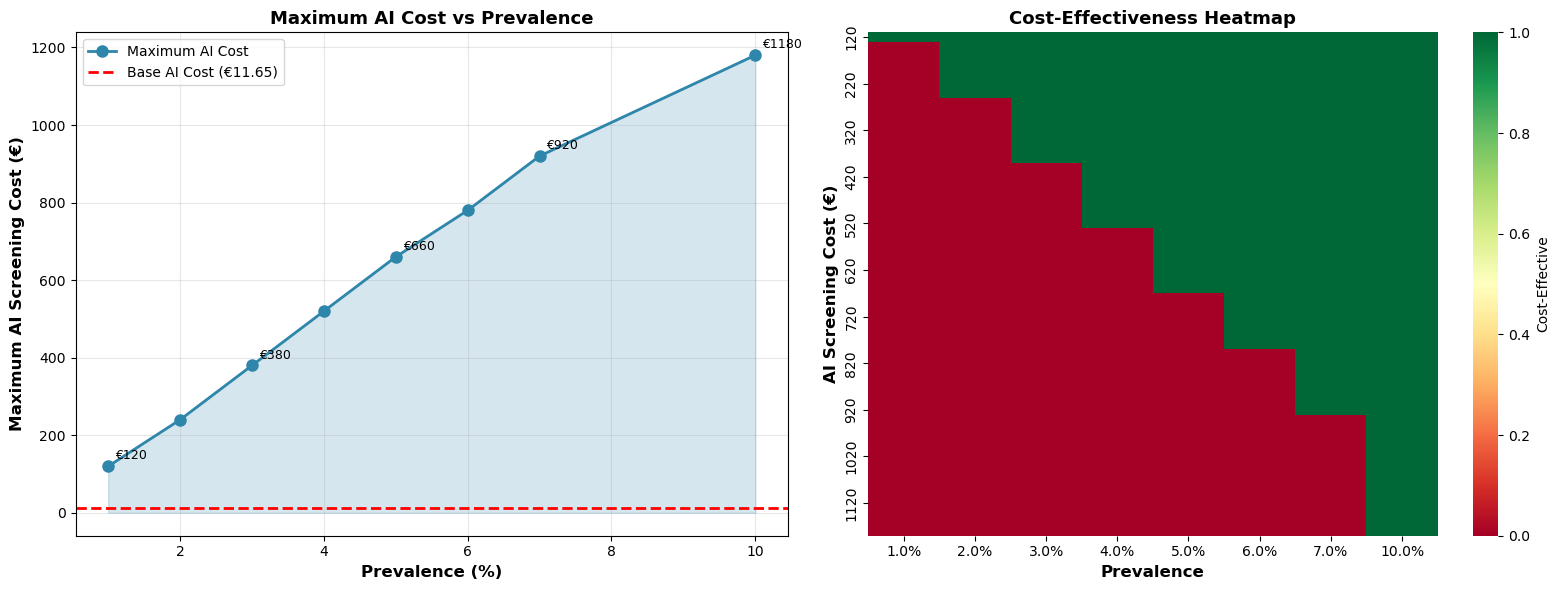


✓ Saved to: ../data/max_ai_cost_by_prevalence.png


In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Maximum AI Cost vs Prevalence
prevalences = summary_df['Prevalence'].values * 100
max_costs = summary_df['Max_AI_Cost'].values

ax1.plot(prevalences, max_costs, 'o-', linewidth=2, markersize=8, color='#2E86AB', label='Maximum AI Cost')
ax1.axhline(y=BASE_AI_COST, color='red', linestyle='--', linewidth=2, label=f'Base AI Cost (€{BASE_AI_COST:.2f})')
ax1.fill_between(prevalences, 0, max_costs, alpha=0.2, color='#2E86AB')

ax1.set_xlabel('Prevalence (%)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Maximum AI Screening Cost (€)', fontsize=12, fontweight='bold')
ax1.set_title('Maximum AI Cost vs Prevalence', fontsize=13, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Add value labels
for i, (prev, cost) in enumerate(zip(prevalences, max_costs)):
    if i % 2 == 0 or i == len(prevalences) - 1:
        ax1.annotate(f'€{cost:.0f}', xy=(prev, cost), xytext=(5, 5),
                    textcoords='offset points', fontsize=9)

# Plot 2: Heatmap of Cost-Effectiveness
pivot_df = results_df.pivot(index='AI_Cost', columns='Prevalence', values='CE')
pivot_df = pivot_df.astype(int)

sns.heatmap(pivot_df, cmap='RdYlGn', cbar_kws={'label': 'Cost-Effective'},
            yticklabels=5, xticklabels=[f'{p:.1%}' for p in PREVALENCE_VALUES],
            ax=ax2, vmin=0, vmax=1)

ax2.set_xlabel('Prevalence', fontsize=12, fontweight='bold')
ax2.set_ylabel('AI Screening Cost (€)', fontsize=12, fontweight='bold')
ax2.set_title('Cost-Effectiveness Heatmap', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/max_ai_cost_by_prevalence.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Saved to: ../data/max_ai_cost_by_prevalence.png")

## 8. Key Insights

In [42]:
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Base case (5%)
base_prev = summary_df[summary_df['Prevalence'] == 0.05].iloc[0]
print(f"\n1. Base Case (5% prevalence):")
print(f"   Maximum AI cost: €{base_prev['Max_AI_Cost']:.0f}")
print(f"   Current AI cost: €{BASE_AI_COST:.2f}")
print(f"   Headroom: €{base_prev['vs_Base']:+.2f} ({base_prev['vs_Base_pct']:+.1f}%)")

# Range across prevalences
valid_costs = summary_df[summary_df['Max_AI_Cost'] > 0]
if len(valid_costs) > 0:
    min_prev_row = valid_costs.iloc[0]
    max_prev_row = valid_costs.iloc[-1]
    
    print(f"\n2. Prevalence Sensitivity:")
    print(f"   At {min_prev_row['Prevalence']:.1%}: Max AI cost = €{min_prev_row['Max_AI_Cost']:.0f}")
    print(f"   At {max_prev_row['Prevalence']:.1%}: Max AI cost = €{max_prev_row['Max_AI_Cost']:.0f}")
    print(f"   Range: €{max_prev_row['Max_AI_Cost'] - min_prev_row['Max_AI_Cost']:.0f}")

# Elasticity
if len(valid_costs) >= 2:
    prev_change = (max_prev_row['Prevalence'] - min_prev_row['Prevalence']) / min_prev_row['Prevalence']
    cost_change = (max_prev_row['Max_AI_Cost'] - min_prev_row['Max_AI_Cost']) / min_prev_row['Max_AI_Cost']
    elasticity = cost_change / prev_change if prev_change > 0 else 0
    
    print(f"\n3. Elasticity:")
    print(f"   {prev_change*100:.0f}% increase in prevalence → {cost_change*100:.0f}% increase in max AI cost")
    print(f"   Elasticity: {elasticity:.2f}")

print(f"\n💡 Total combinations tested: {len(all_results):,}")
print(f"   (Only 1 PSA run = huge time savings!)")


KEY INSIGHTS

1. Base Case (5% prevalence):
   Maximum AI cost: €660
   Current AI cost: €11.65
   Headroom: €+648.35 (+5565.2%)

2. Prevalence Sensitivity:
   At 1.0%: Max AI cost = €120
   At 10.0%: Max AI cost = €1180
   Range: €1060

3. Elasticity:
   900% increase in prevalence → 883% increase in max AI cost
   Elasticity: 0.98

💡 Total combinations tested: 432
   (Only 1 PSA run = huge time savings!)
